# Advanced Content Based Recommendation Net - Optimizations

## Introduction

In this notebook, we aim to enhance the performance of the content-based recommendation system by focusing on key areas of optimization and regularization. Building upon the foundation established in the previous notebook, our goal is to refine the network architecture and training process to achieve better scalability, accuracy, and generalization.

### Objectives:
1. **Optimize the Model**: Apply advanced techniques to improve the training dynamics and convergence speed of the neural network.
2. **Regularization**: Introduce strategies to prevent overfitting, ensuring robust performance on unseen data.
3. **Evaluation and Insights**: Conduct thorough testing to assess the impact of the proposed changes and identify areas for further improvement.

### Planned Optimization Techniques:
1. **Regularization**:
   - Implement **Dropout Layers** to randomly deactivate neurons during training.
   - Introduce **L2 Regularization** (Weight Decay) to penalize large weights.
   - Experiment with versions of the net without using transformer or FM
   - Try out combined loss: MSE + Genre Pred + BPR loss

2. **Optimization**:
   - Use **Adaptive Learning Rate Optimizers** like AdamW or RMSprop for efficient parameter updates.
   - Experiment with **Learning Rate Scheduling** to fine-tune the learning process over epochs.
   - Apply **Gradient Clipping** to prevent exploding gradients.

3. **Architecture Improvements**:
   - Evaluate the impact of **Residual Connections** or **Skip Connections** to improve gradient flow in deeper networks.
   - Test various **Activation Functions** (e.g., ReLU, Leaky ReLU, GELU) for better representation.

4. **Hyperparameter Tuning**:
   - Perform Optuna search with Bayesian optimization for parameters such as learning rate, dropout rate, and regularization strength.

This notebook is designed to systematically explore these enhancements, documenting their effects and iterating toward an optimized recommendation system. By the end of this notebook, we aim to have a well-regularized and efficient model capable of delivering superior recommendations.

---


But first we will reorganize the code a bit, so that previous notebooks are note affected by the changes.

# Building the data pipeline
The following code builds the data pipeline so that we have usable data loaders.

In [3]:
# Watch for changes
%load_ext autoreload
%autoreload 2

import pandas as pd
import torch
from torch.utils.data import DataLoader
from sentence_transformers import SentenceTransformer
import numpy as np
from codebase.v13.data import UserProfileCreator, MovieProfileCreator, LazyGenreMovieLensDataset
import os

# ----------------------------------------------------------------
# Configuration / Constants
# ----------------------------------------------------------------
RATINGS_PATH = 'data/ml-10k-users/ratings.csv'
MOVIES_ENRICHED_PATH = 'data/ml-10k-users/movies_enriched_tags.csv'
USER_ENRICHED_PATH = 'data/ml-10k-users/users_enriched_tags.csv'
USER_EMBEDDINGS_PATH = 'data/ml-10k-users/user_profiles.npy'
MOVIE_EMBEDDINGS_PATH = 'data/ml-10k-users/movie_profiles.npy'
BATCH_SIZE = 512
MODEL_NAME = 'all-mpnet-base-v2'

os.environ["TOKENIZERS_PARALLELISM"] = "false"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------------------------------------------
# 1) Load Data
# ----------------------------------------------------------------
ratings = pd.read_csv(RATINGS_PATH)
movies_enriched = pd.read_csv(MOVIES_ENRICHED_PATH)
users_enriched = pd.read_csv(USER_ENRICHED_PATH)

# Combine favorite genres from users and genres from movies
genre_vocab = sorted(
    set(
        [
            genre.strip() 
            for genre in ','.join(users_enriched['favorite_genres'].dropna()).split(',')
        ]
        + [
            genre.strip() 
            for genre in '|'.join(movies_enriched['genres'].dropna()).split('|')
        ]
    )
)

# ----------------------------------------------------------------
# 2) Filter / Validate IDs
# ----------------------------------------------------------------
valid_user_ids = set(ratings['userId'].unique()).intersection(set(users_enriched['userId'].unique()))
valid_movie_ids = set(ratings['movieId'].unique()).intersection(set(movies_enriched['movieId'].unique()))

ratings = ratings[
    (ratings['userId'].isin(valid_user_ids)) &
    (ratings['movieId'].isin(valid_movie_ids))
]

# Create ID -> index mappings
user_id_to_index = {user_id: idx for idx, user_id in enumerate(valid_user_ids)}
movie_id_to_index = {movie_id: idx for idx, movie_id in enumerate(valid_movie_ids)}

# Map userId/movieId to new indices
ratings['userIndex'] = ratings['userId'].map(user_id_to_index)
ratings['movieIndex'] = ratings['movieId'].map(movie_id_to_index)

# ----------------------------------------------------------------
# 3) Load or Create Profiles
# ----------------------------------------------------------------
text_model = SentenceTransformer(MODEL_NAME).to(device)

user_creator = UserProfileCreator(text_model=text_model, genre_vocab=genre_vocab)
movie_creator = MovieProfileCreator(text_model=text_model, genre_vocab=genre_vocab)

if os.path.exists(USER_EMBEDDINGS_PATH):
    print("Loading user profiles from disk...")
    user_profiles = np.load(USER_EMBEDDINGS_PATH)
    print("User profiles loaded.")
else:
    print("Creating user profiles...")
    filtered_users_df = users_enriched[users_enriched['userId'].isin(valid_user_ids)].reset_index(drop=True)
    user_profiles = user_creator.create_profiles(filtered_users_df)
    np.save(USER_EMBEDDINGS_PATH, user_profiles)
    print("User profiles saved to disk.")

if os.path.exists(MOVIE_EMBEDDINGS_PATH):
    print("Loading movie profiles from disk...")
    movie_profiles = np.load(MOVIE_EMBEDDINGS_PATH)
    print("Movie profiles loaded.")
else:
    print("Creating movie profiles...")
    filtered_movies_df = movies_enriched[movies_enriched['movieId'].isin(valid_movie_ids)].reset_index(drop=True)
    movie_profiles = movie_creator.create_profiles(filtered_movies_df)
    np.save(MOVIE_EMBEDDINGS_PATH, movie_profiles)
    print("Movie profiles saved to disk.")

# ----------------------------------------------------------------
# 4) Continue with the rest of your pipeline (dataloaders, etc.)
# ----------------------------------------------------------------

# Step 3: Temporal split of ratings data
def temporal_split(ratings_df):
    """Split ratings data into train, validation, and test sets temporally."""
    ratings_df = ratings_df.sort_values('timestamp')
    train_end = int(0.7 * len(ratings_df))
    val_end = int(0.85 * len(ratings_df))
    train_data = ratings_df.iloc[:train_end]
    val_data = ratings_df.iloc[train_end:val_end]
    test_data = ratings_df.iloc[val_end:]
    return train_data, val_data, test_data

train_data, val_data, test_data = temporal_split(ratings)

# Lazy evaluation of genre labels
def lazy_extract_genre_labels(data, movie_profiles, genre_vocab):
    """
    Lazily extract genre labels for a dataset using a generator to save memory.
    """
    for idx, row in data.iterrows():
        movie_idx = row['movieIndex']
        genre_vector = movie_profiles[movie_idx, -len(genre_vocab):]  # Extract genre part of the profile
        yield genre_vector

# Create datasets with lazy genre label extraction
train_dataset = LazyGenreMovieLensDataset(train_data, user_profiles, movie_profiles, genre_vocab)
val_dataset = LazyGenreMovieLensDataset(val_data, user_profiles, movie_profiles, genre_vocab)
test_dataset = LazyGenreMovieLensDataset(test_data, user_profiles, movie_profiles, genre_vocab)

# Reduce batch size and number of workers for efficiency
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=4)

print("Data preparation complete!")
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

print()

# Test the dataloaders
for user, movie, rating, genre_labels in train_loader:
    print("User shape (Train):", user.shape)
    print("Movie shape (Train):", movie.shape)
    print("Rating shape: (Train)", rating.shape)
    print("Genre labels shape (Train):", genre_labels.shape)
    print("Sample genre labels:", genre_labels[0])  # Check the first sample's genre labels
    break

print("Done!")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loading user profiles from disk...
User profiles loaded.
Loading movie profiles from disk...
Movie profiles loaded.
Data preparation complete!
Train samples: 1134857
Validation samples: 243184
Test samples: 243184

User shape (Train): torch.Size([512, 791])
Movie shape (Train): torch.Size([512, 1561])
Rating shape: (Train) torch.Size([512])
Genre labels shape (Train): torch.Size([512, 20])
Sample genre labels: tensor([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0.])
Done!


## Let's inspect the data and the pipeline we just created:

In [3]:
def test_genre_label_alignment(movies_enriched, movie_profiles, genre_vocab, genre_start_idx):
    """
    Test if genre labels align with the ground truth in the movies_enriched DataFrame.

    Args:
        movies_enriched (pd.DataFrame): DataFrame with original movie genres.
        movie_profiles (np.ndarray): Precomputed movie profiles containing multi-hot encoded genres.
        genre_vocab (list): List of all possible genres in sorted order.
        genre_start_idx (int): Index in movie_profiles where genre encoding starts.

    Returns:
        None. Prints results of the test.
    """
    # Extract the multi-hot encoded genres from movie_profiles
    num_movies = len(movie_profiles)
    
    genre_profiles = movie_profiles[:, genre_start_idx:genre_start_idx + len(genre_vocab)]
    
    mismatch_count = 0

    # Iterate through movies and compare the genres
    for idx in range(num_movies):
        # Original genres as a set
        original_genres = set(
            [genre.strip() for genre in movies_enriched.iloc[idx]['genres'].split('|') if genre.strip()]
        )

        # Multi-hot decoded genres
        decoded_genres = {genre_vocab[i] for i, value in enumerate(genre_profiles[idx]) if value > 0}
        
        # Check if they match
        if original_genres != decoded_genres:
            mismatch_count += 1
            print(f"Mismatch for movie at index {idx}:")
            print(f"Original genres: {original_genres}")
            print(f"Decoded genres: {decoded_genres}")
            print("---")
    
    # Summary
    if mismatch_count == 0:
        print("All genre labels align perfectly with the ground truth!")
    else:
        print(f"Total mismatches: {mismatch_count}/{num_movies}")

# Example Call
genre_start_idx = (
    movie_profiles.shape[1] - len(genre_vocab) - 768  # Adjust to account for tag embedding size (768)
)

test_genre_label_alignment(
    movies_enriched[movies_enriched['movieId'].isin(valid_movie_ids)], movie_profiles, genre_vocab, genre_start_idx
)

All genre labels align perfectly with the ground truth!


### Test the data loader

In [4]:
# Example: Testing the ContentFeatureMovieLensDataset
def test_dataset(dataset, num_samples=10):
    """
    Test the ContentFeatureMovieLensDataset to verify it repeats user_profiles for corresponding movie_items.
    Args:
        dataset (Dataset): The dataset to test.
        num_samples (int): Number of samples to print for testing.
    """
    print("Testing the dataset...\n")
    print("Sample outputs (user_profile, movie_profile, rating):\n")

    for i in range(min(num_samples, len(dataset))):
        user_profile, movie_profile, rating, genre_labels = dataset[i]
        print(f"User Profile: {user_profile.numpy()[:20]}...")  # Print first 5 values of user profile
        print(f"Movie Profile: {movie_profile.numpy()[:20]}...")  # Print first 5 values of movie profile
        print(f"Rating: {rating.item()}")
        print(f"Genre Labels: {genre_labels.numpy()[:20]}...")  # Print first 5 values of movie profile
        print("-" * 50)

# Create a test dataset instance
# Assuming you already have these variables from your preprocessing:
# - ratings (DataFrame with 'userIndex', 'movieIndex', 'rating')
# - user_profiles (numpy array)
# - movie_profiles (numpy array)

test_dataset_instance = LazyGenreMovieLensDataset(
    ratings, user_profiles, movie_profiles, genre_labels)

# Test the dataset
test_dataset(test_dataset_instance, num_samples=10)

Testing the dataset...

Sample outputs (user_profile, movie_profile, rating):

User Profile: [0.23404256 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.22810121 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]...
Movie Profile: [ 0.06304348  0.05945744  0.15357143  0.7599      0.22736692  0.05326258
  0.08180776  0.00939349 -0.03142862 -0.02561258  0.00362031 -0.02269748
 -0.01764794 -0.04315855  0.03219484  0.06075022  0.02953829  0.04677154
  0.00474784  0.01074326]...
Rating: 4.0
Genre Labels: [ 0.01390333  0.0247205  -0.04106291  0.009196    0.03040015 -0.01574823
 -0.0134384   0.04386886 -0.03664382  0.0571711   0.03600518  0.0285785
  0.02465149 -0.0577763  -0.01429462 -0.01726467  0.00390495  0.02493153
  0.03199285 -0.02188081]...
--------------------------------------------------
User Profile: [0.23404256 0.         0.         0.         0.         0.
 0.         0.         0.         0.       

### Check for NaN:

In [5]:
import numpy as np

def analyze_nan_in_movie_profiles(movie_profiles, column_structure):
    """
    Analyze `movie_profiles` for NaN values and identify affected columns and profiles.
    Args:
        movie_profiles (np.ndarray): Array of movie profiles.
        column_structure (dict): Dictionary defining column ranges for each feature type.
            Example: {
                "numerical_features": (0, 5),  # Start and end index for numerical features
                "overview_embedding": (5, 773),
                "scaled_genres": (773, 791)
            }
    Returns:
        dict: Analysis results, including affected column groups and profile count.
    """
    nan_counts = {}
    total_nan_profiles = 0

    # Analyze each feature group based on column structure
    for feature, (start, end) in column_structure.items():
        feature_data = movie_profiles[:, start:end]
        nan_mask = np.isnan(feature_data)
        nan_count = np.sum(nan_mask)
        nan_profiles = np.sum(np.any(nan_mask, axis=1))  # Profiles with at least one NaN in this range

        nan_counts[feature] = {
            "total_nans": nan_count,
            "affected_profiles": nan_profiles
        }
        total_nan_profiles += nan_profiles

    # Ensure total_nan_profiles isn't double-counted
    total_nan_profiles = np.sum(np.any(np.isnan(movie_profiles), axis=1))

    return {
        "nan_counts": nan_counts,
        "total_nan_profiles": total_nan_profiles
    }

# Define the column structure
column_structure = {
    "numerical_features": (0, 5),
    "overview_embedding": (5, 773),
    "scaled_genres": (773, 791)
}

# Analyze NaN values in movie_profiles
nan_analysis = analyze_nan_in_movie_profiles(movie_profiles, column_structure)

# Display results
print("NaN Analysis Results:")
for feature, stats in nan_analysis["nan_counts"].items():
    print(f"{feature}: Total NaNs = {stats['total_nans']}, Affected Profiles = {stats['affected_profiles']}")

print(f"Total Profiles with NaN Values: {nan_analysis['total_nan_profiles']}")


NaN Analysis Results:
numerical_features: Total NaNs = 0, Affected Profiles = 0
overview_embedding: Total NaNs = 0, Affected Profiles = 0
scaled_genres: Total NaNs = 0, Affected Profiles = 0
Total Profiles with NaN Values: 0


In [6]:
# Validate user_profiles
num_unique_users = ratings['userId'].nunique()
assert user_profiles.shape[0] == num_unique_users, (
    f"Mismatch: user_profiles has {user_profiles.shape[0]} rows, "
    f"but ratings.csv has {num_unique_users} unique userId values."
)
print("Validation passed: user_profiles matches the number of unique users in ratings.csv.")

# Validate movie_profiles
num_unique_movies = ratings['movieId'].nunique()
assert movie_profiles.shape[0] == num_unique_movies, (
    f"Mismatch: movie_profiles has {movie_profiles.shape[0]} rows, "
    f"but ratings.csv has {num_unique_movies} unique movieId values."
)
print("Validation passed: movie_profiles matches the number of unique movies in ratings.csv.")

# Fetch a single batch of data from the train loader
sample_batch = next(iter(train_loader))

# Unpack the batch: user profiles, movie profiles, and ratings
user_profiles, movie_profiles, ratings, genre_labels = sample_batch

# Convert tensors to numpy arrays for inspection
user_profiles = user_profiles.numpy()
movie_profiles = movie_profiles.numpy()
ratings = ratings.numpy()

# Verify alignment
print("Verifying alignment of user profiles, movie profiles, and ratings:")
for i in range(5):  # Check the first 5 rows
    print(f"User Profile {i + 1}: {user_profiles[i][:5]}...")  # Show first few values for brevity
    print(f"Movie Profile {i + 1}: {movie_profiles[i][:5]}...")  # Show first few values for brevity
    print(f"Rating {i + 1}: {ratings[i]}")
    print("-" * 50)

print("Max value in user_profiles:", np.max(user_profiles))
print("Min value in user_profiles:", np.min(user_profiles))
print("Max value in movie_profiles:", np.max(movie_profiles))
print("Min value in movie_profiles:", np.min(movie_profiles))

print()

assert not np.any(np.isnan(user_profiles)), "NaN values found in user_profiles!"
assert not np.any(np.isinf(user_profiles)), "Infinite values found in user_profiles!"
assert not np.any(np.isnan(movie_profiles)), "NaN values found in movie_profiles!"
assert not np.any(np.isinf(movie_profiles)), "Infinite values found in movie_profiles!"

def check_nan_in_dataloader(data_loader):
    """
    Check for NaN values in user_profiles, movie_profiles, and ratings from a DataLoader.
    Args:
        data_loader (DataLoader): The PyTorch DataLoader to check.
    Returns:
        dict: Contains the count of batches with NaN values and examples if found.
    """
    nan_details = {
        "user_profiles": 0,
        "movie_profiles": 0,
        "ratings": 0,
        "example_batch": None
    }

    for batch_idx, (user_profiles, movie_profiles, ratings, genre_labels) in enumerate(data_loader):
        # Check for NaN in user_profiles
        if torch.isnan(user_profiles).any():
            nan_details["user_profiles"] += 1

        # Check for NaN in movie_profiles
        if torch.isnan(movie_profiles).any():
            nan_details["movie_profiles"] += 1

        # Check for NaN in ratings
        if torch.isnan(ratings).any():
            nan_details["ratings"] += 1

        # If any NaN values are found, store an example batch
        if (nan_details["user_profiles"] > 0 or 
            nan_details["movie_profiles"] > 0 or 
            nan_details["ratings"] > 0) and nan_details["example_batch"] is None:
            nan_details["example_batch"] = {
                "batch_idx": batch_idx,
                "user_profiles": user_profiles,
                "movie_profiles": movie_profiles,
                "ratings": ratings
            }

    return nan_details

nan_check_result = check_nan_in_dataloader(train_loader)
print()

# Display the results
print("NaN Check Results:")
print(f"NaN in user_profiles: {nan_check_result['user_profiles']} batches")
print(f"NaN in movie_profiles: {nan_check_result['movie_profiles']} batches")
print(f"NaN in ratings: {nan_check_result['ratings']} batches")

if nan_check_result["example_batch"] is not None:
    print("\nExample Batch with NaN Values:")
    example_batch = nan_check_result["example_batch"]
    print(f"Batch Index: {example_batch['batch_idx']}")
    print(f"User Profiles:\n{example_batch['user_profiles']}")
    print(f"Movie Profiles:\n{example_batch['movie_profiles']}")
    print(f"Ratings:\n{example_batch['ratings']}")
else:
    print("No NaN values found in the data loader!")

Validation passed: user_profiles matches the number of unique users in ratings.csv.
Validation passed: movie_profiles matches the number of unique movies in ratings.csv.
Verifying alignment of user profiles, movie profiles, and ratings:
User Profile 1: [0.78723407 0.         0.         0.         0.        ]...
Movie Profile 1: [0.         0.02505794 0.11190476 0.58       0.00280868]...
Rating 1: 4.0
--------------------------------------------------
User Profile 2: [0.40425533 0.         0.22810121 0.         0.        ]...
Movie Profile 2: [0.0326087  0.06553188 0.11071429 0.75       0.17026614]...
Rating 2: 4.0
--------------------------------------------------
User Profile 3: [0.25531915 0.         0.         0.         0.        ]...
Movie Profile 3: [0.00217391 0.06657537 0.10833333 0.56       0.02105148]...
Rating 3: 4.0
--------------------------------------------------
User Profile 4: [0.68085104 0.         0.         0.         0.        ]...
Movie Profile 4: [0.         0.01

In [13]:
import numpy as np

def find_max_value_of_user_profile(profiles, start_index, end_index):
    """
    Find the profile index with the maximum value over all embedding dimensions.
    Args:
        profiles (np.ndarray): Profiles array (user or movie profiles).
        start_index (int): Starting index for embedding dimensions (e.g., 1 or 4).
    Returns:
        dict: Information about the profile with the maximum value.
    """
    # Extract embedding dimensions
    embeddings = profiles[:, start_index:end_index]

    # Find the maximum value and its location
    max_value = np.max(embeddings)
    profile_index = np.argmax(np.max(embeddings, axis=1))

    # Return details
    return {
        "profile_index": profile_index,
        "max_value": max_value,
        "profile_values": profiles[profile_index][:10],
    }

def find_users_with_multiple_genres(user_profiles, threshold=1):
    """
    Find user profiles with more than one genre assigned.
    Args:
        user_profiles (np.ndarray): User profiles encoded with the structure:
            - 1st column: age
            - Next 18 columns: multi-hot encoded genres
            - Last 2 columns: sex (one-hot encoded).
    Returns:
        dict: {
            "count": Number of matching user profiles,
            "example_profile": One example profile with multiple genres.
        }
    """
    # Extract the genre columns (2nd to 19th columns, 0-indexed)
    genre_columns = user_profiles[:, 1:20]
    genre_columns = (genre_columns > 0).astype(int)

    # Find profiles with more than one genre assigned
    multiple_genres_mask = np.sum(genre_columns, axis=1) > threshold
    matching_profiles = user_profiles[multiple_genres_mask]

    # Return the count and one example (if available)
    return {
        "count": len(matching_profiles),
        "example_profile": matching_profiles[0][:10] if len(matching_profiles) > 0 else None
    }


# Find the user with the maximum age
print(f"Max value profile: {find_max_value_of_user_profile(user_profiles, start_index=1, end_index=20)}")
print()
print(f"Users with multiple genres: {find_users_with_multiple_genres(user_profiles, 2)}")

Max value profile: {'profile_index': 0, 'max_value': 0.22810121, 'profile_values': array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.22810121, 0.        , 0.        , 0.        , 0.        ],
      dtype=float32)}

Users with multiple genres: {'count': 141, 'example_profile': array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.22810121, 0.        , 0.        , 0.        , 0.        ],
      dtype=float32)}


Let's visualize data from the created loaders.

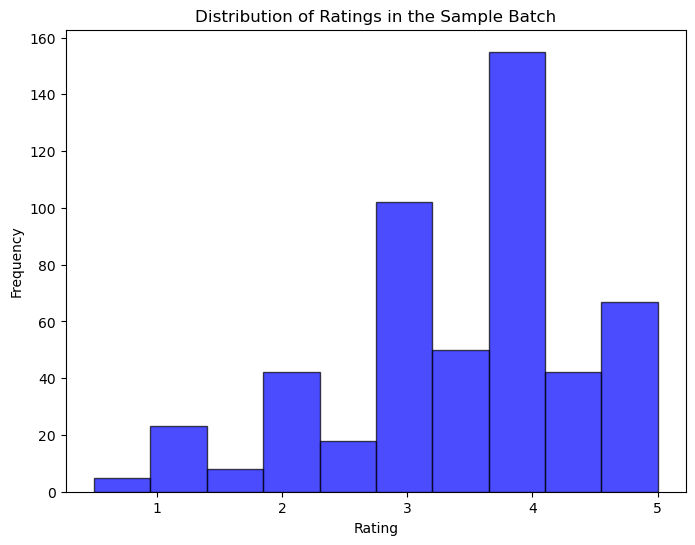

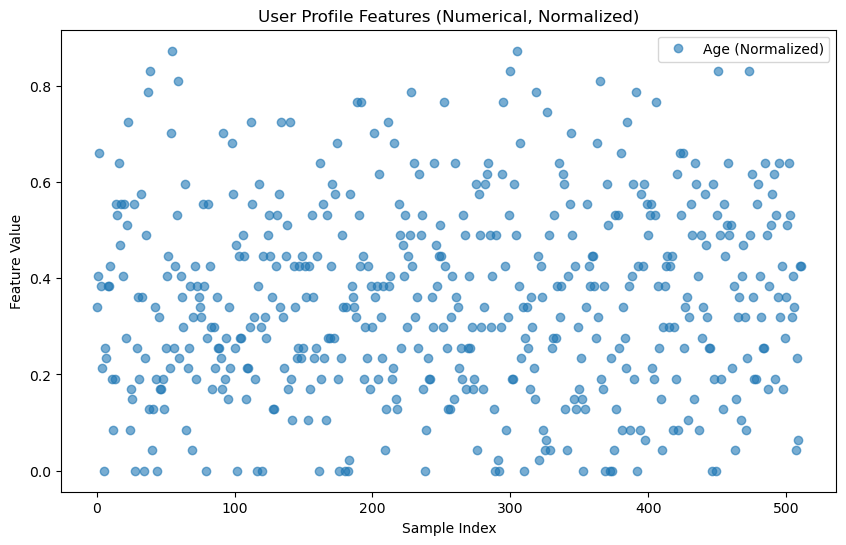

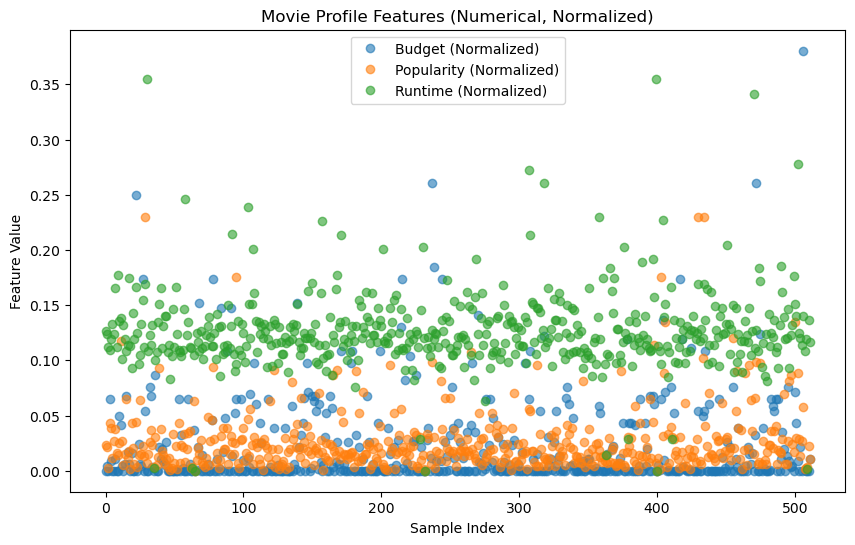

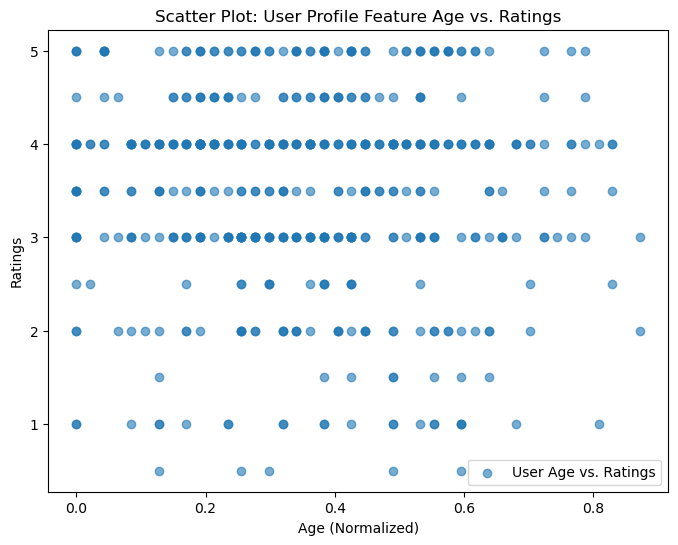

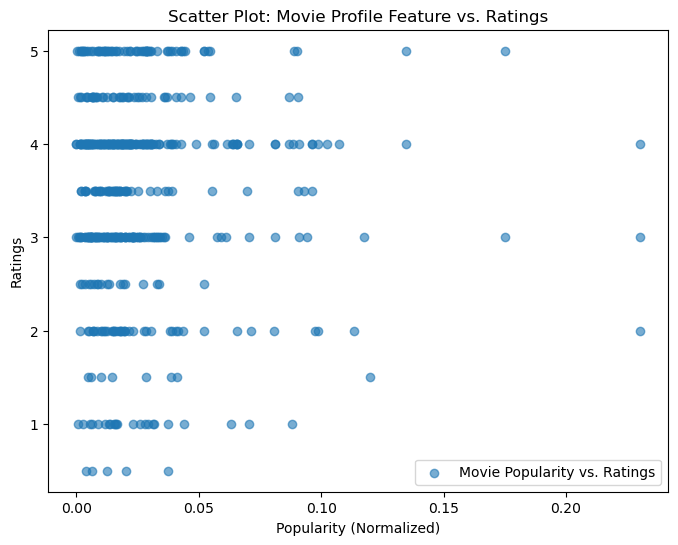

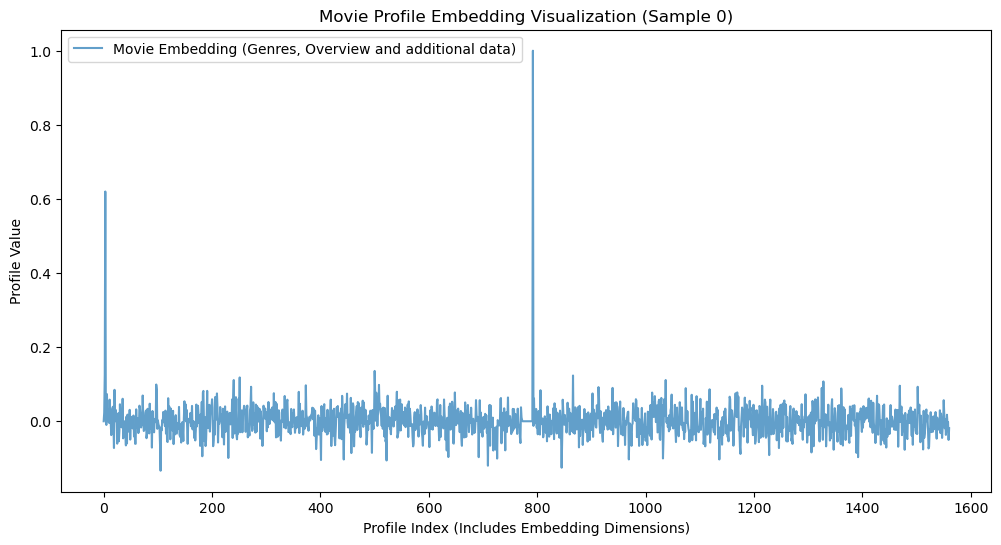

User Profiles data:


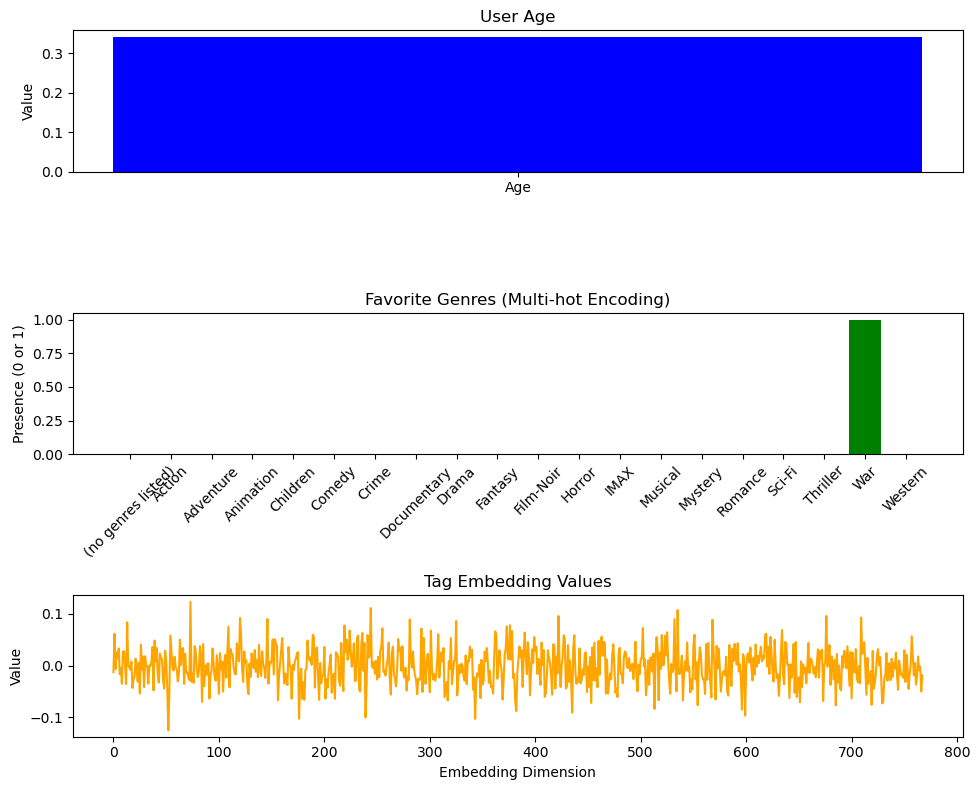

In [2]:
import matplotlib.pyplot as plt

# Helper function to fetch a batch of data from the DataLoader
def get_sample_batch(loader):
    """Fetch a single batch of data from a DataLoader."""
    for batch in loader:
        return batch  # Return the first batch

import matplotlib.pyplot as plt
import numpy as np

def plot_user_profile(user_profiles, genre_vocab, tag_embedding_dim):
    """
    Plot a visualization of a user profile.
    
    Args:
        user_profiles (np.ndarray): Array of user profiles.
        genre_vocab (list): List of all possible genres.
        tag_embedding_dim (int): Dimension of tag embeddings.
    """
    # Select the first user profile for demonstration
    user_profile = user_profiles[0]
    
    # Profile breakdown
    age = user_profile[0]
    genres = user_profile[1:1+len(genre_vocab)]
    tags = user_profile[1+len(genre_vocab):1+len(genre_vocab)+tag_embedding_dim]
    sex = user_profile[1+len(genre_vocab)+tag_embedding_dim:]
    
    # Plot
    _, axes = plt.subplots(3, 1, figsize=(10, 8))
    
    # Age (Numerical Feature)
    axes[0].bar(["Age"], [age], color='blue')
    axes[0].set_title("User Age")
    axes[0].set_ylabel("Value")
    
    # Favorite Genres (Multi-hot)
    axes[1].bar(genre_vocab, genres, color='green')
    axes[1].set_title("Favorite Genres (Multi-hot Encoding)")
    axes[1].set_ylabel("Presence (0 or 1)")
    axes[1].tick_params(axis='x', rotation=45)
    
    # Tags (Embeddings)
    axes[2].plot(tags, color='orange')
    axes[2].set_title("Tag Embedding Values")
    axes[2].set_ylabel("Value")
    axes[2].set_xlabel("Embedding Dimension")
    
    plt.tight_layout()
    plt.show()

# Extract a sample batch from the train loader
sample_batch = get_sample_batch(train_loader)

# Unpack the batch: user profiles, movie profiles, and ratings
user_profiles, movie_profiles, ratings, genre_labels = sample_batch

# Convert tensors to numpy for visualization
user_profiles = user_profiles.numpy()
movie_profiles = movie_profiles.numpy()
ratings = ratings.numpy()

# 1. Visualize the distribution of ratings
plt.figure(figsize=(8, 6))
plt.hist(ratings, bins=10, color='blue', alpha=0.7, edgecolor='black')
plt.title("Distribution of Ratings in the Sample Batch")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

# 2. Visualize numerical features from user profiles (the only numerical feature: age)
plt.figure(figsize=(10, 6))
plt.plot(user_profiles[:, 0], 'o', label='Age (Normalized)', alpha=0.6)
plt.title("User Profile Features (Numerical, Normalized)")
plt.xlabel("Sample Index")
plt.ylabel("Feature Value")
plt.legend()
plt.show()

# 3. Visualize numerical features from movie profiles (first 3 numerical features)
plt.figure(figsize=(10, 6))
plt.plot(movie_profiles[:, 0], 'o', label='Budget (Normalized)', alpha=0.6)
plt.plot(movie_profiles[:, 1], 'o', label='Popularity (Normalized)', alpha=0.6)
plt.plot(movie_profiles[:, 2], 'o', label='Runtime (Normalized)', alpha=0.6)
plt.title("Movie Profile Features (Numerical, Normalized)")
plt.xlabel("Sample Index")
plt.ylabel("Feature Value")
plt.legend()
plt.show()

# 4. Visualize the relationship between a user profile feature and ratings
plt.figure(figsize=(8, 6))
plt.scatter(user_profiles[:, 0], ratings, alpha=0.6, label="User Age vs. Ratings")
plt.title("Scatter Plot: User Profile Feature Age vs. Ratings")
plt.xlabel("Age (Normalized)")
plt.ylabel("Ratings")
plt.legend()
plt.show()

# 5. Visualize the relationship between a movie profile feature and ratings
plt.figure(figsize=(8, 6))
plt.scatter(movie_profiles[:, 1], ratings, alpha=0.6, label="Movie Popularity vs. Ratings")
plt.title("Scatter Plot: Movie Profile Feature vs. Ratings")
plt.xlabel("Popularity (Normalized)")
plt.ylabel("Ratings")
plt.legend()
plt.show()

# Inspect embeddings for a random movie profile
plt.figure(figsize=(12, 6))
plt.plot(movie_profiles[0, 0:], label="Movie Embedding (Genres, Overview and additional data)", alpha=0.7)
plt.title("Movie Profile Embedding Visualization (Sample 0)")
plt.xlabel("Profile Index (Includes Embedding Dimensions)")
plt.ylabel("Profile Value")
plt.legend()
plt.show()

print("User Profiles data:")
plot_user_profile(user_profiles, genre_vocab, tag_embedding_dim=768)

You may wonder why the Profile Index (Includes Embedding Dimensions) are larger than the embedding dimension of a single SBERT encoded text. This is because the final embedding vector contains multiple embeddings, the numerical embeddings as textual embeddings too.

**User Profile**
Numerical Features:

***Embeddings***
Tags embedding = 768 dimensions

Age, genres, sex = 1(age) + number(genres) + 2(sex) dimensions + 768(tags_user).

Total Dimensions:
1(Numerical) + 18(Genres one-hot) + 2(Categorial) = 21 + 768 dimensions.


**Movie Profile**
Numerical Features:

Budget, popularity, runtime, vote_average, vote_count = 5 dimensions.

Genres = 18

***Embeddings***:
Overview embedding = 768 dimensions.
Tags embedding = 768 dimensions.

5 (Numerical) + 18 (Genres) + 768 (Overview) + 768 (tags_by_users) = 791 + 768 dimensions.

# The recommendation net and training code

The **code** for the recommendation net can be found in **codebase/models.py** or **codebase/models_advanced.py**.

The training code:

In [4]:
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import os
from datetime import datetime
import sys
import torch.nn.functional as F

def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)  # Xavier initialization
        if m.bias is not None:
            nn.init.zeros_(m.bias)

def get_unique_log_dir(base_dir="tensorboard_logs", run_name="baseline_model"):
    """
    Generate a unique log directory based on timestamp.

    Args:
        base_dir (str): Base directory for TensorBoard logs.

    Returns:
        str: Unique log directory path.
    """
    # Generate timestamp
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    
    # Combine base directory with timestamp
    log_dir = os.path.join(base_dir, f"{run_name}_{timestamp}")
        
    return log_dir

def multitask_loss_with_bpr(
    criterion,
    predictions,
    rating,
    genre_pred=None,
    genre_labels=None,
    alpha=0.5,
    beta=0.5
):
    """
    Multitask loss combining regression loss, auxiliary classification loss, and vectorized BPR ranking loss.
    
    Args:
        criterion: Regression loss function (e.g., MSE or MAE) for the ratings.
        predictions: Predicted scores for the main task. Shape: [batch_size].
        rating: Ground-truth ratings (continuous). Shape: [batch_size].
        genre_pred: Predicted genre logits. Shape: [batch_size, num_genres] (optional).
        genre_labels: Multi-hot ground-truth genre labels. Shape: [batch_size, num_genres] (optional).
        alpha: Weight for the auxiliary classification loss (between 0 and 1).
        beta: Weight for the BPR ranking loss (>= 0).

    Returns:
        Total loss combining:
          - Regression loss for ratings.
          - Optional BCE loss for genre prediction.
          - BPR loss for relative ranking of items.
    """
    # 1) Main regression loss (e.g., MSE for rating)
    #    predictions, rating => shape [batch_size]
    loss = criterion(predictions, rating)

    # 2) Optional auxiliary classification loss (multitask: genres)
    if genre_pred is not None and genre_labels is not None:
        bce_loss = nn.BCEWithLogitsLoss()(genre_pred, genre_labels)
        # Weighted combo of regression loss + classification loss
        # alpha controls how much we trust the regression vs. classification
        loss = alpha * loss + (1 - alpha) * bce_loss

    # 3) Vectorized BPR ranking loss
    if beta > 0:
        # Pairwise differences for ratings
        diff_ratings = rating.unsqueeze(1) - rating.unsqueeze(0)  # [batch_size, batch_size]
        diff_predictions = predictions.unsqueeze(1) - predictions.unsqueeze(0)  # [batch_size, batch_size]

        # Valid pairs mask: Only keep pairs where rating[i] > rating[j]
        valid_pairs = diff_ratings > 0  # [batch_size, batch_size]

        # Apply BPR loss only to valid pairs
        if valid_pairs.any():
            bpr_loss = -F.logsigmoid(diff_predictions[valid_pairs]).mean()
        else:
            bpr_loss = torch.tensor(0.0, device=predictions.device)

        # Weight this ranking loss by 'beta'
        loss += beta * bpr_loss

    # 4) Ensure 'loss' is scalar
    loss = loss.mean()

    # 5) Optional safety check
    if loss < 0:
        print(f"Exit because of negative loss: {loss.item()}. alpha={alpha}, beta={beta}")
        sys.exit(1)

    return loss

def train(
    model,
    optimizer,
    scheduler,
    criterion,
    num_epochs=10,
    patience=3,
    model_path='saved_weights/rec-net/best_model.pth',
    log_dir='tensorboard_logs/rec-net',
    log_every_n_batches=10,  # Log every N batches
    alpha=0.2, # Weight for the genre prediction loss
    beta=0.5 # Weight for the ranking loss
):
    # TensorBoard writer
    if log_dir is not None:
        writer = SummaryWriter(log_dir=log_dir)

    # Early stopping variables
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        # Training loop
        for batch_idx, (user_profile, movie_profile, rating, genre_labels) in enumerate(train_loader):
            user_profile = user_profile.to(device)
            movie_profile = movie_profile.to(device)
            rating = rating.to(device).view(-1, 1)  # Ensure rating is a column vector
            genre_labels = genre_labels.to(device)  # Multi-hot genre labels

            # Forward pass
            predictions, genre_pred = model(user_profile, movie_profile)
            loss = multitask_loss_with_bpr(criterion, predictions, rating, genre_pred, genre_labels, alpha, beta=beta)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Log metrics every N batches
            if log_dir is not None and batch_idx % log_every_n_batches == 0 and genre_pred is not None:
                with torch.no_grad():
                    # Log genre prediction accuracy
                    genre_accuracy = ((torch.sigmoid(genre_pred) > 0.5) == genre_labels).float().mean().item()
                    writer.add_scalar('Accuracy/Genre (val)', genre_accuracy, epoch)

        # Calculate average training loss
        avg_train_loss = total_loss / len(train_loader)

        # Validation loop
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for user_profile, movie_profile, rating, genre_labels in val_loader:
                user_profile = user_profile.to(device)
                movie_profile = movie_profile.to(device)
                rating = rating.to(device).view(-1, 1)
                genre_labels = genre_labels.to(device)

                predictions, genre_pred = model(user_profile, movie_profile)
                loss = multitask_loss_with_bpr(criterion, predictions, rating, genre_pred, genre_labels, alpha, beta=beta)
                val_loss += loss.item()
                
                if log_dir is not None and genre_pred is not None:
                    # Log genre prediction accuracy
                    genre_accuracy = ((torch.sigmoid(genre_pred) > 0.5) == genre_labels).float().mean().item()
                    writer.add_scalar('Accuracy/Genre (val)', genre_accuracy, epoch)

        avg_val_loss = val_loss / len(val_loader)

        # Step the scheduler based on validation loss
        if scheduler is not None:
            scheduler.step(avg_val_loss)
        
        # Early stopping logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_without_improvement = 0
            torch.save(model.state_dict(), model_path)  # Save the best model
        else:
            epochs_without_improvement += 1
            print(f"Epochs without improvement: {epochs_without_improvement}")

        # Log progress
        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Log losses to TensorBoard
        if log_dir is not None:
            writer.add_scalar('Loss/Train', avg_train_loss, epoch)
            writer.add_scalar('Loss/Validation', avg_val_loss, epoch)

        # Check for early stopping
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs!")
            break

    # Load the best model after early stopping
    model.load_state_dict(torch.load(model_path, weights_only=True))
    print("Training complete! Best model loaded.")

    # Close TensorBoard writer
    if log_dir is not None:
        writer.close()

    return avg_val_loss

# Use Optuna to do a hyperparameter search.

In [ ]:
# Watch for changes
%load_ext autoreload
%autoreload 2

import optuna
import torch.nn as nn
import torch.optim as optim
from codebase.v13.recommendation_net import ContentRecommendationNet

def objective(trial):
    # Define the parameter search space
    user_dim = user_profiles.shape[1]          # Dimensionality of user profiles
    movie_dim = movie_profiles.shape[1]        # Dimensionality of movie profiles
    
    dense_hidden = trial.suggest_int("dense_hidden", 64, 256, step=32)
    fm_latent_dim = trial.suggest_int("fm_latent_dim", 64, 256, step=32)
    fm_hidden_dim = trial.suggest_int("fm_hidden_dim", 64, 256, step=32)

    # Ensure transformer_d_model is divisible by transformer_nhead
    transformer_nhead = trial.suggest_int("transformer_nhead", 2, 8, step=2)
    transformer_d_model = trial.suggest_int(
        "transformer_d_model", transformer_nhead * 16, transformer_nhead * 32, step=transformer_nhead * 8
    )
    
    transformer_feedforward = trial.suggest_int("transformer_feedforward", 128, 512, step=64)
    transformer_layers = trial.suggest_int("transformer_layers", 1, 4)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)

    # Instantiate the model with sampled hyperparameters
    model = ContentRecommendationNet(
        user_dim=user_dim,
        movie_dim=movie_dim,
        dense_hidden=dense_hidden,
        fm_latent_dim=fm_latent_dim,
        fm_hidden_dim=fm_hidden_dim,
        transformer_d_model=transformer_d_model,
        transformer_nhead=transformer_nhead,
        transformer_feedforward=transformer_feedforward,
        transformer_layers=transformer_layers,
        use_fm=True,
        use_transformer=True,
        multitask=True,
        genres_vocab_size=len(genre_vocab)
    )
    
    model = model.to(device)

    # Define optimizer and criterion
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    return train(
        model, optimizer, criterion, 20, 5, model_path='saved_weights/rec-net/best_model_10k-users_optuna.pth', log_dir=None, alpha=0.7)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Watch for changes
%load_ext autoreload
%autoreload 2

# Create a study
study = optuna.create_study(direction="minimize")  # Minimize validation loss
study.optimize(objective, n_trials=25)  # Run 25 trials

# Print best hyperparameters
print("Best hyperparameters:")
print(study.best_params)
print("Best validation loss:")
print(study.best_value)

# Manual training

In [12]:
# Watch for changes
%load_ext autoreload
%autoreload 2

from codebase.v13.recommendation_net import ConfigurableRecommendationNet

# General model configuration
learning_rate = 0.0006649557984750292
weight_decay = 0.0 # No weight decay because of Adam optimizer
num_epochs = 50
patience = 3  # Number of epochs to wait for improvement
user_dim = user_profiles.shape[1]          # Dimensionality of user profiles
movie_dim = movie_profiles.shape[1]        # Dimensionality of movie profiles

# Model configuration parameters for ConfigurableRecommendationNet
dense_hidden = 256     # Hidden dimension size for dense layers
fm_latent_dim = 64     # Latent dimensionality for the FM layer
fm_hidden_dim = 128
transformer_d_model = 128  # Dimensionality of transformer embeddings
transformer_nhead = 4      # Number of attention heads in the transformer
transformer_feedforward = 512  # Feedforward network size in transformer
transformer_layers = 2     # Number of transformer layers
multitask = True          # Set True for multi-task (rating + auxiliary predictions)
num_genres = len(genre_vocab)            # Number of genres (used if multitask=True)
alpha = 0.6               # Weight for the auxiliary task (genre prediction)
beta = 0.5                # Weight for the ranking loss

# Instantiate the model with the parameters
model = ConfigurableRecommendationNet(
    user_dim=user_dim,
    movie_dim=movie_dim,
    dense_hidden=dense_hidden,
    fm_latent_dim=fm_latent_dim,
    fm_hidden_dim=fm_hidden_dim,
    transformer_d_model=transformer_d_model,
    transformer_nhead=transformer_nhead,
    transformer_feedforward=transformer_feedforward,
    transformer_layers=transformer_layers,
    multitask=multitask,
    use_fm=True,
    use_transformer=True,
    genres_vocab_size=num_genres if multitask else 0,
    activation='LeakyReLU'
)

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

model.apply(initialize_weights)

criterion = nn.MSELoss()  # Mean Squared Error for regression (e.g., ratings)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

train(
    model, optimizer, scheduler, criterion, num_epochs, patience, 
    model_path='saved_weights/rec-net/best_model_manual.pth', 
    log_dir=None,
    alpha=alpha, beta=beta
)
#get_unique_log_dir("tensorboard_logs", model.__class__.__name__), alpha=0.7

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/oliver/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/50], Train Loss: 1.0291, Val Loss: 0.9898
Epochs without improvement: 1
Epoch [2/50], Train Loss: 0.8720, Val Loss: 0.9899
Epoch [3/50], Train Loss: 0.8460, Val Loss: 0.9837
Epochs without improvement: 1
Epoch [4/50], Train Loss: 0.8318, Val Loss: 0.9940
Epochs without improvement: 2
Epoch [5/50], Train Loss: 0.8209, Val Loss: 0.9936
Epochs without improvement: 3
Epoch [6/50], Train Loss: 0.8124, Val Loss: 1.0086
Early stopping triggered after 6 epochs!
Training complete! Best model loaded.


1.008563376727857

In [20]:
# Save the model state dictionary
model_path = "saved_weights/rec-net/adv-10k-users-with-genres-alpha-0.7-fm-tuned-unscaled.pth"

# Save the model state dictionary for AdvancedContentRecommendationNet
torch.save({
    'model_state_dict': model.state_dict(),
    'user_dim': user_dim,
    'movie_dim': movie_dim,
    'dense_hidden': dense_hidden,
    'fm_latent_dim': fm_latent_dim,
    'fm_hidden_dim': fm_hidden_dim,
    'transformer_d_model': transformer_d_model,
    'transformer_nhead': transformer_nhead,
    'transformer_feedforward': transformer_feedforward,
    'transformer_layers': transformer_layers,
    'multitask': multitask,
    'num_genres': len(genre_vocab) if multitask else 0,
    'learning_rate': learning_rate,
}, model_path)

print(f"Model saved to {model_path}")

Model saved to saved_weights/rec-net/adv-10k-users-with-genres-alpha-0.7-fm-tuned-unscaled.pth


In [22]:
from codebase.v13.recommendation_net import ConfigurableRecommendationNet

model_path = "saved_weights/rec-net/adv-10k-users-with-genres-alpha-0.7-fm-tuned-unscaled.pth"

# Reinitialize the model architecture
checkpoint = torch.load(model_path, weights_only=True)

# AdvancedContentRecommendationNet model
loaded_model = ConfigurableRecommendationNet(
    user_dim=checkpoint['user_dim'],
    movie_dim=checkpoint['movie_dim'],
    dense_hidden=checkpoint['dense_hidden'],
    fm_latent_dim=checkpoint['fm_latent_dim'],
    fm_hidden_dim=checkpoint['fm_hidden_dim'],
    transformer_d_model=checkpoint['transformer_d_model'],
    transformer_nhead=checkpoint['transformer_nhead'],
    transformer_feedforward=checkpoint['transformer_feedforward'],
    transformer_layers=checkpoint['transformer_layers'],
    multitask=checkpoint['multitask'],
    genres_vocab_size=checkpoint['num_genres'],
    use_fm=True,
    use_transformer=True
).to(device)

loaded_model.load_state_dict(checkpoint['model_state_dict'])
loaded_model.eval()

/home/oliver/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


ConfigurableRecommendationNet(
  (user_dense): Linear(in_features=791, out_features=256, bias=True)
  (movie_dense): Linear(in_features=1561, out_features=256, bias=True)
  (fm_layer): FactorizationMachineLayer()
  (fm_proj): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (transformer_block): TransformerAttentionBlock(
    (transformer): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05, elem

# Let's validate the trained model.

In [ ]:
def count_unique_profiles_from_loader(data_loader):
    """
    Count the number of unique user and movie profiles in a DataLoader.
    Args:
        data_loader (DataLoader): PyTorch DataLoader with batches containing 
                                  user_profiles, movie_profiles, and ratings.
    Returns:
        dict: A dictionary with the counts of unique user and movie profiles.
    """
    all_user_profiles = []
    all_movie_profiles = []

    # Collect all user and movie profiles from the loader
    for user_profiles, movie_profiles, _, _ in data_loader:
        all_user_profiles.append(user_profiles.cpu().numpy())
        all_movie_profiles.append(movie_profiles.cpu().numpy())
            
    # Concatenate all batches into single arrays
    all_user_profiles = np.vstack(all_user_profiles)
    all_movie_profiles = np.vstack(all_movie_profiles)

    # Find unique rows in user and movie profiles
    unique_user_profiles = np.unique(all_user_profiles, axis=0)
    unique_movie_profiles = np.unique(all_movie_profiles, axis=0)

    return {
        "unique_users": unique_user_profiles.shape[0],
        "unique_movies": unique_movie_profiles.shape[0]
    }

# Count users and movies in each loader
train_counts = count_unique_profiles_from_loader(train_loader)
val_counts = count_unique_profiles_from_loader(val_loader)
test_counts = count_unique_profiles_from_loader(test_loader)

# Print results
print("Train Loader:")
print(f"Unique Users: {train_counts['unique_users']}")
print(f"Unique Movies: {train_counts['unique_movies']}")

print("\nValidation Loader:")
print(f"Unique Users: {val_counts['unique_users']}")
print(f"Unique Movies: {val_counts['unique_movies']}")

print("\nTest Loader:")
print(f"Unique Users: {test_counts['unique_users']}")
print(f"Unique Movies: {test_counts['unique_movies']}")

In [6]:
import numpy as np
import torch
from collections import defaultdict

def create_user_to_test_movies_map(test_data, relevance_threshold=3.5):
    """
    Create a map of userIndex -> set of 'relevant' movies from the test set.
    For a rating-based approach, we often define relevant = rating >= threshold.
    """
    user_to_test_movies = defaultdict(set)
    
    for row in test_data.itertuples():
        # row.userIndex, row.movieIndex, row.rating
        if row.rating >= relevance_threshold:
            user_to_test_movies[row.userIndex].add(row.movieIndex)
            
    return dict(user_to_test_movies)

In [7]:
from torch.utils.data import DataLoader
from codebase.data import EvaluationDataset

def build_eval_dataloader(test_data, user_profiles, movie_profiles, batch_size=1024):
    eval_dataset = EvaluationDataset(test_data, user_profiles, movie_profiles)
    eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=False)
    return eval_loader

In [8]:
from collections import defaultdict
import numpy as np

def compute_precision_at_k_fast(
    test_data,
    user_profiles,
    movie_profiles,
    model,
    k=5,
    rating_threshold=3.5,
    train_val_data=None
):
    """
    Optimized computation of Precision@K for all users in the test set while ensuring recommended movies
    exclude already-rated items.
    """
    device = next(model.parameters()).device  # Use the model's device (e.g., GPU)

    # 1) Create mapping: user -> set of ground truth movies in the test set
    user_to_test_movies = defaultdict(set)
    for _, row in test_data.iterrows():
        if row["rating"] >= rating_threshold:
            user_to_test_movies[row["userIndex"]].add(row["movieIndex"])

    # 2) Create mapping: user -> set of movies already rated in train/val
    user_to_rated_movies = defaultdict(set)
    if train_val_data is not None:
        for _, row in train_val_data.iterrows():
            user_to_rated_movies[row["userIndex"]].add(row["movieIndex"])

    # 3) Prepare user profiles and all movie profiles in torch tensors
    user_profiles_tensor = torch.tensor(user_profiles, dtype=torch.float32).to(device)
    movie_profiles_tensor = torch.tensor(movie_profiles, dtype=torch.float32).to(device)

    # 4) Store predictions for each user
    user_to_predictions = {}

    model.eval()
    with torch.no_grad():
        for user_idx in test_data["userIndex"].unique():
            # Exclude movies already rated by the user
            rated_movies = user_to_rated_movies.get(user_idx, set())
            candidate_movies = [m for m in range(movie_profiles.shape[0]) if m not in rated_movies]

            # Skip users with no candidate movies
            if not candidate_movies:
                user_to_predictions[user_idx] = []
                continue

            # Prepare user and candidate movie profiles
            user_profile = user_profiles_tensor[user_idx].unsqueeze(0).repeat(len(candidate_movies), 1)
            candidate_movie_profiles = movie_profiles_tensor[candidate_movies]

            # Compute scores in a single forward pass
            scores, _ = model(user_profile, candidate_movie_profiles)
            scores = scores.squeeze().cpu().numpy()

            # Store top-K predictions
            top_k_indices = np.argsort(scores)[-k:][::-1]
            user_to_predictions[user_idx] = [(candidate_movies[i], scores[i]) for i in top_k_indices]

    # 5) Compute Precision@K per user
    precision_per_user = []
    for user_idx, pred_list in user_to_predictions.items():
        # Get top-K movie predictions
        top_k_movies = [m for m, _ in pred_list]

        # Get ground truth movies from the test set
        ground_truth_movies = user_to_test_movies.get(user_idx, set())

        # Compute hits
        if ground_truth_movies:
            hits = len(set(top_k_movies).intersection(ground_truth_movies))
            precision_k = hits / k
        else:
            precision_k = 0  # No ground truth => Precision@K is 0 for this user

        precision_per_user.append(precision_k)

    # Return the mean Precision@K
    return np.mean(precision_per_user) if precision_per_user else 0.0


In [13]:
# Assuming test_data, train_data, val_data, user_profiles, and movie_profiles are prepared
train_val_data = pd.concat([train_data, val_data])

precision_at_k = compute_precision_at_k_fast(
    test_data=test_data,
    user_profiles=user_profiles,
    movie_profiles=movie_profiles,
    model=model,
    k=5,
    rating_threshold=4.0,
    train_val_data=train_val_data
)

print(f"Precision@5: {precision_at_k:.4f}")


Precision@5: 0.1850


## Experiment Results

| **Experiment**                                                                 | **Result (Precision)** | **Notes**                                                                           |
|--------------------------------------------------------------------------------|-------------------------|------------------------------------------------------------------------------------|
| 10k-users and genres (`alpha=0.7`)                                             | 0.1427                  | Genres were scaled (to the size of text embeddings) down; try again without scaling. |
| 10k-users and genres (`alpha=0.7`)                                             | 0.1723                  | Scaling genres makes a difference.                                                |
| 10k-users and genres (`alpha=0.7`) - with FM / no transformer                  | 0.0139                  | The transformer is extremely important here.                                       |
| 10k-users and genres (`alpha=0.7`) - no FM / with transformer                  | 0.2129                  | FM lowers precision significantly.                                                |
| 10k-users and genres (`alpha=0.7`) - with tuned FM / with transformer          | 0.1622                  | FM is not beneficial in this configuration.                                       |
| 10k-users and genres (`alpha=0.7`) - with more tuned FM / with transformer     | 0.2374                  | FM shows potential; not ready to discard it yet.                                  |
| 10k-users and genres (`alpha=0.7, beta=0.5`) - FM / with transformer + BPR loss | **0.2767**                  | BPR loss was introduced and performs well!                                                            |
| 10k-users and genres (`alpha=0.7, beta=0.5`) - FM / with transformer + BPR loss, LR sched, L2 weight reg | 0.1087                  | L2 weight decay negatively impacts performance.                                   |
| 10k-users and genres (`alpha=0.7, beta=0.5`) - FM / with transformer + BPR loss, LR sched, No L2 | 0.1965                  | BPR loss seems to perform better without L2.                                      |
| 10k-users and genres (`alpha=0.7, beta=0.5`) - FM / with transformer + BPR loss, No LR sched, No L2 | 0.1711                  | Well, this is not stringent...                                      |
| 10k-users and genres (`alpha=0.7, beta=0.5`) - FM / with transformer + BPR loss, No LR sched, No L2, GeLU | 0.1402                  | GeLU not good here?

I have noticed something interesting here: The MSE and Genre loss is not decisive here! The model with the best loss is not the model with yields the best precisions. So why is that so?

## Understanding Loss Metric and Evaluation Metric Mismatch in Recommendation Systems

In recommendation systems, it is possible to encounter a situation where the model with the **best loss** during training does not yield the **best precision** or evaluation metric. This discrepancy arises because the **loss metric** used for optimization may not align perfectly with the target evaluation metric.

### 1. Loss Metric vs. Target Evaluation Metric

#### Why This Happens:
- **Training Loss**: The loss function (e.g., MSE for regression or cross-entropy for classification) optimizes a specific mathematical objective during training.
- **Evaluation Metric**: Precision, recall, F1-score, or ranking-based metrics (e.g., Precision@K) reflect the model's real-world performance.
- **Mismatch**: A model with a lower MSE may not necessarily rank items better than a model with slightly higher MSE.

#### Example:
In recommendation systems:
- **Loss Function**: Mean Squared Error (MSE) minimizes the difference between predicted and actual ratings.
- **Evaluation Metric**: Precision@K measures how many of the top-K recommended items are relevant to the user.

### 2. Recommendations for Addressing the Mismatch

#### Align the Loss Function with the Evaluation Metric
To optimize for metrics like Precision@K or Recall@K, modify the loss function to align better with ranking-based objectives. Some common loss functions include:

- **Pairwise Ranking Loss**: Optimizes the relative ordering of items.
- **Listwise Loss**: Focuses on the overall ranking of items.
- **Binary Classification Loss**: For implicit feedback, use binary cross-entropy loss instead of MSE.

#### Add Auxiliary Losses
If a single loss (e.g., MSE) is insufficient, combine it with other objectives:

- **Hybrid Loss**:
  Combine regression loss with ranking loss to balance accuracy and ranking:

total_loss = α * MSE + β * Ranking Loss

#### Use Metrics During Training
Log metrics like **Precision@K**, **Recall@K**, or **NDCG@K** during training. Use these to select the best hyperparameters rather than relying solely on the loss.

#### Hyperparameter Tuning for the Target Metric
When performing hyperparameter optimization, use the evaluation metric (e.g., Precision@K) as the objective, not the training loss. This ensures that the best hyperparameters are selected for real-world performance.

### 3. Potential Issues with Loss Metrics

#### Overfitting to Loss
A model may overfit to the loss function, leading to poor generalization. Use early stopping based on evaluation metrics, not just the loss.

#### Loss Doesn’t Capture Real-World Performance
Loss functions like MSE treat all errors equally, but in recommendation systems, the relevance of items is more important than minor errors in predicted scores.

#### Imbalanced Data
If the dataset is imbalanced (e.g., very few positive interactions), the loss might be dominated by the majority class.

### 4. Suggestions for Improvement

#### Evaluate Precision During Training
Monitor evaluation metrics like Precision@K during training and compare them to the loss.

#### Switch to a Ranking Loss
If ranking performance is the primary goal, use ranking-based loss functions such as Pairwise or Listwise Loss.

#### Use Weighted Loss
Incorporate weights to emphasize relevant items in the loss calculation.

### 5. Summary
- The loss metric may not always align with the evaluation metric.
- Align the loss function with the evaluation metric, especially for ranking-based objectives.
- Optimize hyperparameters based on evaluation metrics (e.g., Precision@K).
- Monitor evaluation metrics alongside the loss during training.

By adjusting the loss function and focusing on evaluation metrics during hyperparameter tuning, it is possible to better optimize for real-world performance in recommendation systems.


# Conclusion and Interpretation

In this notebook, we explored advanced techniques to optimize and regularize a content-based recommendation system. Our focus was on systematically improving model performance through architectural enhancements, better optimization strategies, and robust regularization techniques. Below is a summary of what was achieved:

## Experiments Conducted:
1. **Regularization Techniques**:
   - Implemented **Dropout** layers to prevent overfitting.
   - Applied **L2 Regularization (Weight Decay)** to penalize large weights and encourage simpler models.
   - Experimented with combined loss functions, such as **MSE + Genre Prediction Loss + BPR Loss**, to balance multiple objectives.

2. **Optimization Strategies**:   
   - Introduced **Learning Rate Schedulers** to dynamically adjust learning rates during training.   

3. **Architectural Enhancements**:
   - Evaluated the impact of **Residual Connections** on gradient flow and model depth.
   - Tested different **Activation Functions** (e.g., ReLU, Leaky ReLU, GELU) for their effectiveness in non-linear transformations.

4. **Hyperparameter Tuning**:
   - Performed tuning with tools like Optuna to optimize key parameters such as learning rate, dropout rate, and regularization strength.

5. **Evaluation and Testing**:
   - Conducted detailed evaluations to measure the impact of the changes.
   - Assessed improvements in scalability, accuracy, and generalization.

## Key Insights and Interpretation:
- **Regularization**: L2 regularization decreased the performance dramatically. Maybe different weight decay rates could change this?
- **Loss Combinations**: Incorporating multiple objectives into the loss function (e.g., Genre Prediction and BPR Loss) led to more nuanced and balanced recommendations.
- **Optimization**: Adaptive optimizers like Adam, combined with learning rate scheduling, ensured stable and efficient convergence across training epochs.
- **Architecture**: Residual connections didn't improve the performance (it actually decreased performance) and GeLU didn't made a big difference.